In [1]:
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from stlpy.STL import STLFormula, LinearPredicate
from stlpy.systems import LinearSystem
from stlpy.solvers import GurobiMICPSolver


In [2]:

######################################
# System definition
######################################
# We represent each ring with its horizontal and
# vertical position xr = [px,py]. The total state is the positions
# of all rings x = [x1,x2,x3,...].
#
# Control input u = [u1,u2,...] is similarly composed of
# velocities ur = [vx,vy] for each ring.

# Number of rings (max 5 for now)
N = 2

# Time horizon (max number of control actions)
T = 30

# Ring sizes
rh = 0.1                     # height
rw = [0.5,0.4,0.3,0.2,0.1]   # width

# The control input is change total position of each ring, and output
# is both position and velocity y = [x,u]
A = np.eye(2*N)
B = np.eye(2*N)
C = np.vstack([np.eye(2*N), np.zeros((2*N,2*N))])
D = np.vstack([np.zeros((2*N,2*N)), np.eye(2*N)])
sys = LinearSystem(A,B,C,D)

# Initial state (all stacked on first peg)
x0 = np.array([0 if i%2==0 else rh/2+(i-1)/2*rh for i in range(2*N)])

# Cost function penalizes large inputs
Q = np.zeros((2*N,2*N))
R = np.eye(2*N)

# Workspace boundaries
u_min = np.array([-1,-1]*N)
u_max = np.array([1,1]*N)
x_min = np.array([0,rh/2]*N)
x_max = np.array([2.5,2]*N)


In [3]:

#######################################
# STL Specification
#######################################
# The STL specification constraints both the (approximate) dynamics
# of the system (e.g., only one ring can move at a time) as well as
# the rules of the game (e.g., we can only stack smaller rings on larger ones)
eps = 1e-1   # small constant so that we can use strict > and <

# Some convienience functions for generating a selection vector
# for x position, y position, x velocity, and y velocity of each ring
#
# These selection vectors put a 1 in the corresponding output slot
#   y = [px1, py1, px2, py2, ..., vx1, vy1, vx2, vy2, ... ]
# and a zero everywhere else. This allows us to compactly define
# corresponding predicates.
px_vec = lambda i : np.hstack([[1,0] if j==i else [0,0] for j in range(N)] + [[0,0] for j in range(N)]).flatten()
py_vec = lambda i : np.hstack([[0,1] if j==i else [0,0] for j in range(N)] + [[0,0] for j in range(N)]).flatten()
vx_vec = lambda i : np.hstack([[0,0] for j in range(N)] + [[1,0] if j==i else [0,0] for j in range(N)]).flatten()
vy_vec = lambda i : np.hstack([[0,0] for j in range(N)] + [[0,1] if j==i else [0,0] for j in range(N)]).flatten()

# Define some basic formulas for each ring. Store equivalent formulas in a list
# indexed by ring
no_x_movement = []
no_y_movement = []
no_movement = []
for i in range(N):
    _no_x_movement = LinearPredicate(vx_vec(i),0) & LinearPredicate(-vx_vec(i),0) # vx <= 0 & vx >= 0
    _no_y_movement = LinearPredicate(vy_vec(i),0) & LinearPredicate(-vy_vec(i),0)
    _no_movement = _no_x_movement & _no_y_movement

    no_x_movement.append(_no_x_movement)
    no_y_movement.append(_no_y_movement)
    no_movement.append(_no_movement)

x_movement = []
y_movement = []
movement = []
for i in range(N):
    _x_movement = LinearPredicate(vx_vec(i),eps) | LinearPredicate(-vx_vec(i),eps) # vx >= eps or -vx >= eps
    _y_movement = LinearPredicate(vy_vec(i),eps) | LinearPredicate(-vy_vec(i),eps) # vx >= eps or -vx >= eps
    _movement = _x_movement | _y_movement

    x_movement.append(_x_movement)
    y_movement.append(_y_movement)
    movement.append(_movement)

on_ground = []
for i in range(N):
    #_on_ground = LinearPredicate(-py_vec(i),-rh/2)
    _on_ground = LinearPredicate(-py_vec(i),-N*rh+rh/2)
    on_ground.append(_on_ground)

on_first_pole = []
on_second_pole = []
on_third_pole = []
for i in range(N):
    _on_first_pole = LinearPredicate(px_vec(i),0) & LinearPredicate(-px_vec(i),0)
    _on_second_pole = LinearPredicate(px_vec(i),1) & LinearPredicate(-px_vec(i),-1)
    _on_third_pole = LinearPredicate(px_vec(i),2) & LinearPredicate(-px_vec(i),-2)

    on_first_pole.append(_on_first_pole)
    on_second_pole.append(_on_second_pole)
    on_third_pole.append(_on_third_pole)

above_poles = []
below_poles = []
for i in range(N):
    _above_poles = LinearPredicate(py_vec(i), 1.2)
    _below_poles = _above_poles.negation()

    above_poles.append(_above_poles)
    below_poles.append(_below_poles)

# Define formulas such that below[i][j] denotes the fact that
# ring i is below ring j
below = []
for i in range(N):
    _below = []
    for j in range(N):
        i_below_j = LinearPredicate(py_vec(j)-py_vec(i),rh)
        _below.append(i_below_j)
    below.append(_below)

# Similar formulas denoting being at different poles
different_poles = []
for i in range(N):
    _different = []
    for j in range(N):
        i_gt_j = LinearPredicate(px_vec(i)-px_vec(j), eps)
        j_gt_i = LinearPredicate(px_vec(j)-px_vec(i), eps)
        diff = i_gt_j | j_gt_i | above_poles[i] | above_poles[j]
        _different.append(diff)
    different_poles.append(_different)

# All rings must reach the third pole at the same time
all_on_third_pole = on_third_pole[0] & no_movement[0]
for i in range(1,N):
    all_on_third_pole = all_on_third_pole & on_third_pole[i] & no_movement[i]

# Start building the specification
spec = all_on_third_pole.eventually(T,T)

# Movement rules that apply to each ring individually
for i in range(N):
    # Can't move in the x-direction unless above the poles
    no_move_below_poles = no_x_movement[i] | above_poles[i]
    spec = spec & no_move_below_poles.always(0,T)

    # Must be on a pole if they're below a certain height
    on_a_pole = on_first_pole[i] | on_second_pole[i] | on_third_pole[i]
    spec = spec & (on_a_pole | above_poles[i]).always(0,T)

    # Can move horizontally or vertically, but not both
    move_one_direction = no_x_movement[i] | no_y_movement[i]
    spec = spec & move_one_direction.always(0,T)

    # If a ring isn't moving, it must be on the ground
    stop_on_ground = movement[i] | on_ground[i]
    spec = spec & stop_on_ground.always(0,T)

# Only one ring can move at a time
for (i,j) in itertools.combinations(range(N),2):
    max_one_moves = no_movement[i] | no_movement[j]
    spec = spec & max_one_moves.always(0,T)

# Rings on the same pole must be stacked large-to-small
for i in range(N):
    for j in range(i+1,N):
        small_on_big = different_poles[i][j] | below[i][j]
        spec = spec & small_on_big.always(0,T)


In [4]:

#######################################
# Solution visualization
#######################################

def plot_solution(x, save_fname=None):
    """
    Given a solution x, create a matplotlib animation of the solution.

    Args:
        x:          The (2*num_rings, T) numpy array representing
                    the optimal positions of the rings.
        same_fname: (optional) filename for saving the animation. Doesn't
                    save if not provided.
    """
    # set up axes
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim((-0.1,2))
    ax.set_xlim((-0.5,2.5))

    # Poles
    plt.plot([0,0],[0,1],'k',linewidth=5)
    plt.plot([1,1],[0,1],'k',linewidth=5)
    plt.plot([2,2],[0,1],'k',linewidth=5)

    # Ground
    plt.fill_between([-100,100],[-10,0],color='k')

    # Rings
    rings = []
    colors = ['red','blue','orange','green','purple']
    for i in range(N):
        r = plt.Rectangle([0,0], rw[i], rh, color=colors[i])
        ax.add_patch(r)
        rings.append(r)

    def data_gen():
        # Generate data that gets sent to update the animation
        gen_list = (np.hstack([x[:,t],t]) for t in range(x.shape[1]))
        return gen_list

    def update(data):
        # Update the animation based on data
        for i in range(N):
            px = data[2*i]
            py = data[2*i+1]
            t = data[-1]

            rings[i].set_xy([px-rw[i]/2,py-rh/2])

            ax.set_title("t=%d" % t)

    ani = FuncAnimation(fig, update, data_gen)

    # Save the animation to a file
    #ani.save("towers_of_hanoi.mp4")

    plt.show()


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-29
Setting up optimization problem...
Setup complete in 4.3957555294036865 seconds.
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5682 rows, 4430 columns and 13381 nonzeros
Model fingerprint: 0x5cfabfdd
Variable types: 2837 continuous, 1593 integer (1593 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 1e+03]
Presolve removed 4477 rows and 3661 columns
Presolve time: 0.03s
Presolved: 1205 rows, 769 columns, 2826 nonzeros
Variable types: 173 continuous, 596 integer (596 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.0

C:\Users\iteun\AppData\Local\Temp\ipykernel_19940\3965365351.py:55: UserWarning: frames=<function plot_solution.<locals>.data_gen at 0x0000026CE2025280> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, data_gen)


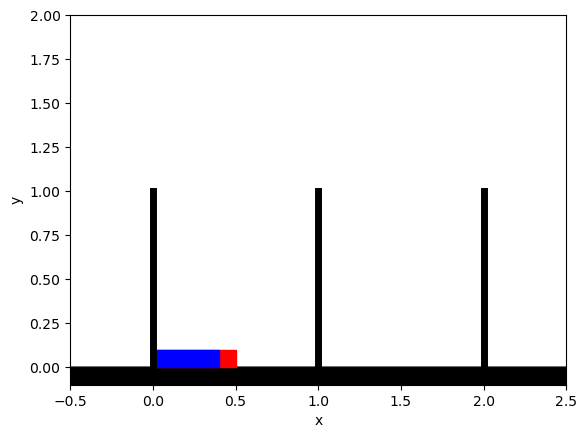

c:\Users\iteun\miniconda3\lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [5]:

#######################################
# Solve the puzzle!
#######################################
spec.simplify()

solver = GurobiMICPSolver(spec, sys, x0, T, robustness_cost=False)
solver.AddControlBounds(u_min, u_max)
solver.AddStateBounds(x_min, x_max)

x, u, _, _ = solver.Solve()

if x is not None:
    plot_solution(x)